In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import os
from typing import List,Optional
import shutil

In [6]:
metadata = pd.read_csv("./data/HAM10000_metadata.csv")
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [20]:
cancers = ["akiec","bcc","mel"]
metadata["is_cancer"] = np.where(metadata["dx"].isin(cancers),"cancer","not_cancer")
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_cancer
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,not_cancer
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,not_cancer
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,not_cancer
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,not_cancer
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,not_cancer
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,cancer
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,cancer
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,cancer
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,cancer


In [21]:
list(metadata["is_cancer"].value_counts())

[8061, 1954]

In [3]:
def sort_images(input_directory:str,output_directory:str,how:str="is_cancer") -> Optional[str]:
    '''
    Function to sort the images according to diagnose or binary 
    according to if it is benign or malignant.
    parameters:
    input_directory (required) - Where the images are stored
    output_directory (required) - 
    how - how to sort by, "is_cancer" - binary,"diagnose" - by diagnose
    '''
    def make_dirs(dirs:List[str])-> None:
        for dir in dirs:
            os.makedirs(os.path.join(output_directory,dir),exist_ok=True)
    image_list = os.listdir(input_directory)
    if how=="is_cancer":
        dirs = list(metadata["is_cancer"].unique())
        make_dirs(dirs)
        method = "is_cancer"
    elif how=="diagnose":
        dirs = list(metadata["dx"].unique())
        make_dirs(dirs)
        method = "dx"
    else:
        print("how parameter invalid")
        return("how parameter invalid")
    
    for image in tqdm(image_list):
        shutil.copy(f"{input_directory}{image}",f'{output_directory}/{metadata.loc[metadata["image_id"] == image[:-4]][method].values[0]}')
    

In [7]:
sort_images("./data/HAM10000/","./data/images",how="diagnose")

100%|██████████| 10015/10015 [00:18<00:00, 529.65it/s]


In [24]:
sort_images("./data/HAM10000_images_part_2/","./data/images",how="diagnose")

100%|██████████| 5015/5015 [00:10<00:00, 482.14it/s]


In [26]:
training = tf.keras.preprocessing.image_dataset_from_directory("./data/images/",label_mode="categorical",validation_split=0.2,subset="training",seed=123)
validation = tf.keras.preprocessing.image_dataset_from_directory("./data/images/",label_mode="categorical",validation_split=0.2,subset="validation",seed=123)

Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


In [27]:
class_names = training.class_names
class_names

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

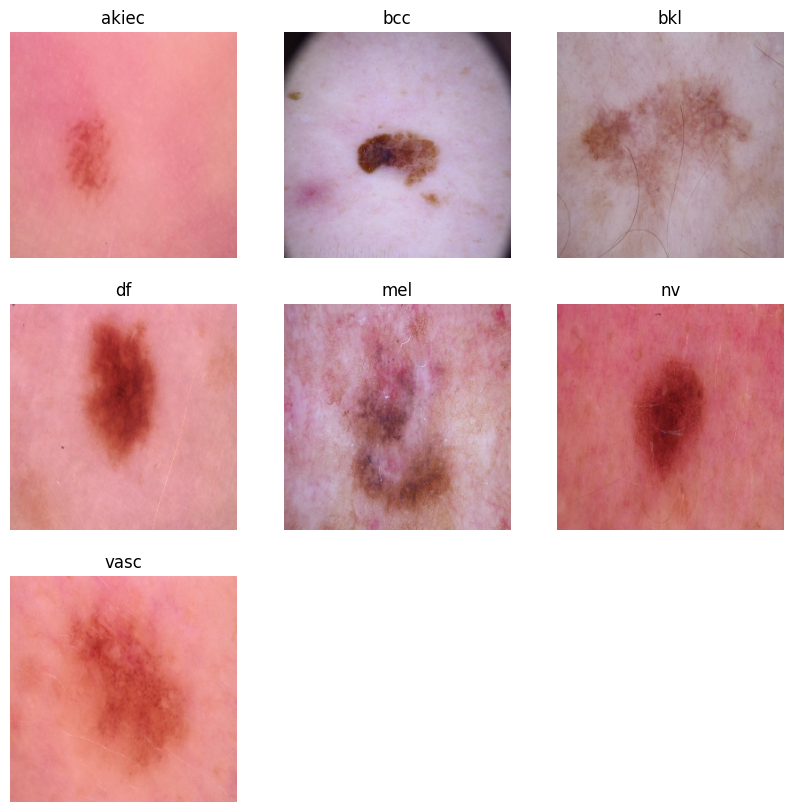

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
  for i in range(7):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [30]:
for image_batch, labels_batch in training:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 7)


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

training = training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
normalization_layer = tf.keras.layers.Rescaling(1./255,input_shape=(256, 256, 3))
from tensorflow.keras import layers,models

In [38]:
num_classes = len(class_names)

model = models.Sequential([
  normalization_layer,
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(7)
])

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.FalseNegatives(),"accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                  

In [35]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16454248132220589083
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1721342363
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 541198739056098856
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [36]:
class_weight = {0:1,1:5}

In [40]:
epochs = 10

with tf.device("/GPU:0"):
    history = model.fit(training,epochs=epochs,validation_data=validation)

Epoch 1/10
251/251 [==============================] - 25s 94ms/step - loss: 0.2712 - false_negatives_1: 3701.0000 - accuracy: 0.6681 - val_loss: 0.2586 - val_false_negatives_1: 657.0000 - val_accuracy: 0.6720
Epoch 2/10
251/251 [==============================] - 23s 93ms/step - loss: 0.2620 - false_negatives_1: 3351.0000 - accuracy: 0.6689 - val_loss: 0.2586 - val_false_negatives_1: 657.0000 - val_accuracy: 0.6720
Epoch 3/10
251/251 [==============================] - 23s 91ms/step - loss: 0.2622 - false_negatives_1: 3322.0000 - accuracy: 0.6689 - val_loss: 0.2597 - val_false_negatives_1: 657.0000 - val_accuracy: 0.6720
Epoch 4/10
 97/251 [==========>...................] - ETA: 13s - loss: 0.2626 - false_negatives_1: 1336.0000 - accuracy: 0.6667

KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [58]:
history.history["val_false_negatives_3"]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [59]:
model.save("class_model.h5")

In [60]:
loaded = tf.keras.models.load_model("./class_model.h5")

In [12]:
import cv2

test_image = cv2.imread("./data/HAM10000_images_part_1/ISIC_0024548.jpg")
test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
test_image.shape

(450, 600, 3)

In [13]:
test_image = test_image/255
test_image.shape

(450, 600, 3)

In [14]:
test_image = cv2.resize(test_image,(256,256))
test_image.shape

(256, 256, 3)

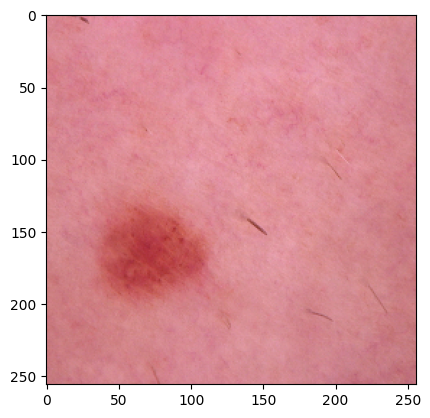

In [16]:
plt.imshow(test_image)

In [17]:
expanded = tf.expand_dims(test_image,axis=0)

NameError: name 'tf' is not defined

In [85]:
loaded.predict(expanded)[0][0]

1/1 [==============================] - 0s 18ms/step


3.0937335